In [ ]:
# load all necessary packages
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets,layers,models
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# Shape of X_train
X_train.shape


(50000, 32, 32, 3)

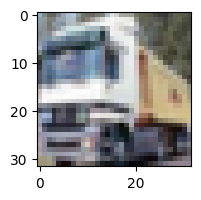

In [5]:
#checking the image and its quality
plt.figure(figsize=(15,2))
plt.imshow(X_train[1])

In [ ]:
# define the classes according to index no.
classes=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
# check y_train shape
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [ ]:
# Flatten labels
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

In [ ]:
# check shape after change
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [ ]:
# function to dispaly image with its lable 
def plot_sample(X,y,index):
    plt.figure(figsize=(15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

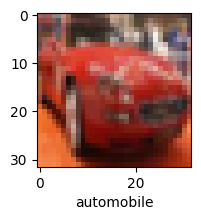

In [ ]:
# plot the sample
plot_sample(X_train,y_train,5)

In [ ]:
# train-test split 

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,   # 20% of training = 10k images
    random_state=42
)

# y_val also needs to be flattened
y_val = y_val.reshape(-1,)


In [ ]:
# Preprocessing function: resize and normalize
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  
    image = image / 255.0                        # normalize to [0,1]
    return image, label

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess).batch(32)

In [ ]:
# Load MobileNetV2 without the top layer 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model for now
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Creating the fully-connected layer

x = base_model.output
x = GlobalAveragePooling2D()(x)  # reduces each feature map to a single number
x = Dense(128, activation='relu')(x)  # intermediate layer
output = Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # labels are integers (0-9)
    metrics=['accuracy']
)


In [ ]:
# Fitting the model 
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  
)


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - accuracy: 0.7053 - loss: 0.8623 - val_accuracy: 0.8027 - val_loss: 0.5613
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.8100 - loss: 0.5476 - val_accuracy: 0.8137 - val_loss: 0.5335
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.8262 - loss: 0.4965 - val_accuracy: 0.7983 - val_loss: 0.5802
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - accuracy: 0.8405 - loss: 0.4507 - val_accuracy: 0.8163 - val_loss: 0.5180
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - accuracy: 0.8525 - loss: 0.4183 - val_accuracy: 0.8024 - val_loss: 0.5645


### The accuracy is quite low (0.8525), so we unfreeze the last 10 CNN layers to improve learning

In [18]:
# Unfreeze last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile again with small learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune_10 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 50ms/step - accuracy: 0.7220 - loss: 0.8014 - val_accuracy: 0.7879 - val_loss: 0.6292
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.8099 - loss: 0.5406 - val_accuracy: 0.8048 - val_loss: 0.5603
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - accuracy: 0.8292 - loss: 0.4837 - val_accuracy: 0.8174 - val_loss: 0.5271
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.8445 - loss: 0.4469 - val_accuracy: 0.8228 - val_loss: 0.5101
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.8533 - loss: 0.4142 - val_accuracy: 0.8308 - val_loss: 0.4916


### The accuracy does not improve drastically (0.8533), so we unfreeze the last 30 CNN layers to improve learning

In [19]:
# Unfreeze last 10 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile again with small learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune_10 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 55ms/step - accuracy: 0.7949 - loss: 0.5864 - val_accuracy: 0.8322 - val_loss: 0.4987
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.8592 - loss: 0.4021 - val_accuracy: 0.8449 - val_loss: 0.4532
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.8865 - loss: 0.3227 - val_accuracy: 0.8515 - val_loss: 0.4352
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.9050 - loss: 0.2703 - val_accuracy: 0.8579 - val_loss: 0.4217
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 48ms/step - accuracy: 0.9205 - loss: 0.2297 - val_accuracy: 0.8593 - val_loss: 0.4170


### The accuracy improves drastically (0.9205)

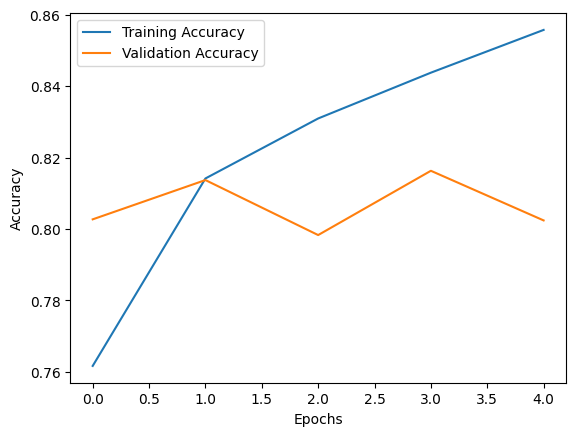

In [ ]:
# Plotting the training and validation accuracy over epochs to visualize how well the model is learning.
# This helps check for overfitting or underfitting.
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


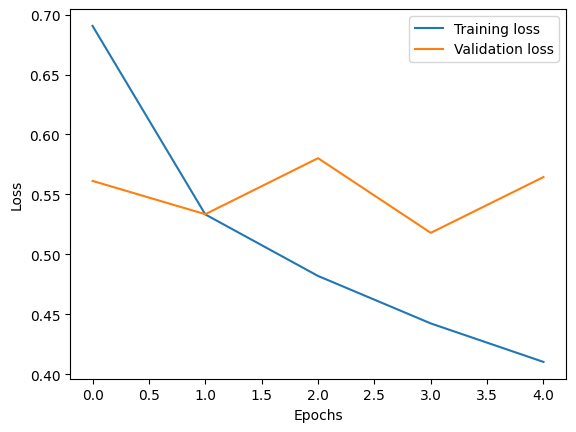

In [ ]:
# Plotting training and validation loss over epochs.
# This helps visualize how well the model is minimizing error and to detect overfitting.
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Validation loss starts increasing while training loss keeps decreasing, it signals overfitting.

In [ ]:
# Load base model without top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze most layers 
for layer in base_model.layers[:-30]:   # only last 30 layers are trainable
    layer.trainable = False

# custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Flatten
x = Dropout(0.3)(x)              # Drop 30% neurons randomly
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Role of Dropout in Reducing Overfitting:**  
The `Dropout(0.3)` layer randomly sets 30% of the input neurons to zero during each training step.  
This prevents the model from relying too heavily on specific neurons, forcing it to learn more robust and generalized features, which helps reduce overfitting.


In [ ]:
# Early stopping callback to prevent overfitting
# Monitors 'val_accuracy' during training.
# If validation accuracy does not improve for 3 consecutive epochs (patience=3), training stops early.
# restore_best_weights=True ensures the model reverts to the epoch with the best validation accuracy.

early_stop= EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Training the model for 5 epochs on train_ds with validation on val_ds.
# Using the EarlyStopping callback

history_afterdropout=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 59ms/step - accuracy: 0.7533 - loss: 0.7277 - val_accuracy: 0.5791 - val_loss: 3.1273
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.8718 - loss: 0.3781 - val_accuracy: 0.7470 - val_loss: 1.6166
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.9033 - loss: 0.2830 - val_accuracy: 0.8072 - val_loss: 1.0156
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.9236 - loss: 0.2215 - val_accuracy: 0.8552 - val_loss: 0.7597
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.9422 - loss: 0.1694 - val_accuracy: 0.8430 - val_loss: 0.7955


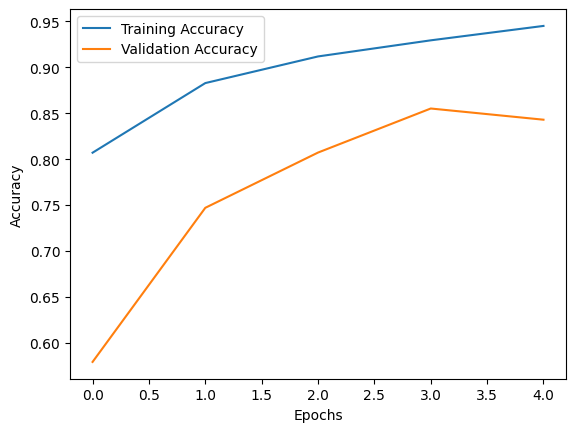

In [ ]:
# Plotting the training and validation accuracy over epochs to visualize how well the model is learning.
# This helps check for overfitting or underfitting.

plt.plot(history_afterdropout.history['accuracy'],label='Training Accuracy')
plt.plot(history_afterdropout.history['val_accuracy'],label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**As a result, the validation accuracy no longer shows a steep drop after a few epochs, and the gap between training and validation accuracy has reduced — a clear sign of reduced overfitting.**

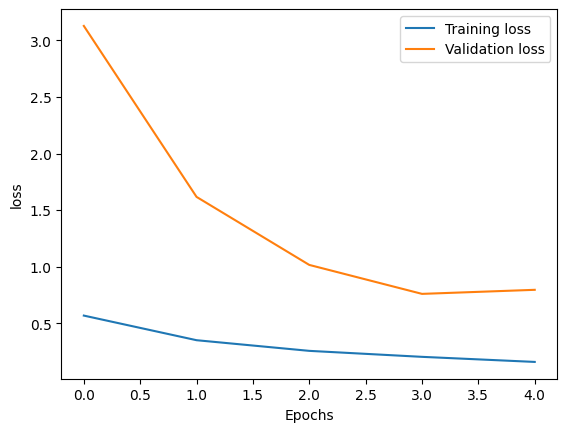

In [ ]:
# Plotting training and validation loss over epochs.
# This helps visualize how well the model is minimizing error and to detect overfitting.
plt.plot(history_afterdropout.history['loss'],label='Training loss')
plt.plot(history_afterdropout.history['val_loss'],label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


**Training vs Validation Loss Behavior**  

In the graph, both **training loss** and **validation loss** decrease together over the epochs.  
This "hand-in-hand" reduction indicates:  

- The model is **learning effectively** and minimizing error on both training and unseen validation data.  
- The slight flattening of validation loss after epoch 3 shows the model is reaching a point of **stability**,  
  and overfitting is not strongly present.  
  


In [ ]:
# Saving the trained model in Keras format as 'cnn_model.keras'.

model.save("cnn_model.keras")
from google.colab import files
files.download("cnn_model.keras")

### Then using Google Colab's files API to download the saved model file so it can be stored locally for later use or deployment.